# Introduction to Backtesting Algorithms
## By: Carter Carlson

### Concept
When it comes to backtesting the performance of a rebalanced portfolio, there are several common questions that come into play.  

NOTE: This notebook is purely an example of what to consider when generating your own backtests.

Common questions include:
* What do I use for my dataset?
* How frequent should the algorithm trade?
* What constitutes a long/short signal?
* How should my portfolio be allocated during a long/short signal vs. a neutral position?
    * If we remain neutral, should the algorithm still rebalance?
    * How do I include fees?
* How do I compare a rebalanced portfolio to a non-rebalanced portfolio?

### What do I use for my dataset?

For our backtests, we will be using hourly and daily Ethereum candlestick data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

eth_1h = pd.read_csv('../data/ETH.csv')

print(f"Start date: {eth_1h['date'].iat[0]}")
print(f"End date: {eth_1h['date'].iat[-1]}")

Start date: 2019-01-01 00:00:00
End date: 2019-11-28 23:00:00


In [2]:
eth_1h.head()

,date,open,high,low,close,volume
0,2019-01-01 00:00:00,132.74,133.50,132.67,133.36,6204.28401
1,2019-01-01 01:00:00,133.36,134.30,133.01,133.56,10214.95098
2,2019-01-01 02:00:00,133.56,135.30,133.19,134.52,16342.20664
3,2019-01-01 03:00:00,134.55,134.78,133.55,133.70,14895.35710
4,2019-01-01 04:00:00,133.72,134.14,133.66,133.86,6388.10191


In [3]:
# Group ETH into 1d candles
# https://pypi.org/project/TAcharts
from TAcharts.utils import group_candles

eth_1d = group_candles(eth_1h, interval=24)
eth_1d.head()

,date,open,high,low,close,volume
0,2019-01-01 00:00:00,132.74,140.67,131.00,138.99,4.151021e+05
1,2019-01-02 00:00:00,138.91,155.37,138.30,151.93,1.018141e+06
2,2019-01-03 00:00:00,151.78,154.20,143.11,153.33,7.381434e+05
3,2019-01-04 00:00:00,153.11,159.26,144.66,154.51,8.914434e+05
4,2019-01-05 00:00:00,157.70,157.80,147.51,150.47,6.645218e+05


## How frequent should the algorithm trade?

For our example, we want our algorithm to trade once/week on the same hour.  Instead of picking an arbitrary time to rebalance on, let's find:
* The day with the lowest price volatility
* On that day, the hour with the lowest price volatility

From this, we can have our algorithm rebalance at a time where price is most constant.

### Daily Volatility

In [4]:
def calc_pct_change(high, low, _open):
    return (high - low) / _open

In [5]:
eth_1d['pct_change'] = calc_pct_change(eth_1d['high'], eth_1d['low'], eth_1d['open'])
eth_1d['weekday'] = pd.DatetimeIndex(eth_1d['date']).day_name()

daily_volatility = eth_1d.groupby('weekday')['pct_change'].mean().sort_values(ascending=False)
print(daily_volatility)

weekday
Tuesday      0.070740
Wednesday    0.066079
Sunday       0.063304
Monday       0.062416
Friday       0.061621
Thursday     0.059621
Saturday     0.052946
Name: pct_change, dtype: float64


#### Conclusion: Saturday has the lowest average daily volatility

### Hourly Volatility

In [6]:
eth_1h['pct_change'] = calc_pct_change(eth_1h['high'], eth_1h['low'], eth_1h['open'])
eth_1h['hour'] = pd.DatetimeIndex(eth_1h['date']).hour

# Only take volatility from Saturday
eth_1h_saturday = eth_1h[pd.DatetimeIndex(eth_1h['date']).day_name() == 'Saturday']

hourly_volatility = eth_1h.groupby('hour')['pct_change'].mean().sort_values(ascending=False)
print(hourly_volatility)

hour
11    0.015472
19    0.014008
10    0.013859
9     0.013478
18    0.013072
17    0.012644
8     0.012570
15    0.012349
7     0.012239
16    0.011714
5     0.011542
12    0.011506
4     0.011314
3     0.011192
6     0.011139
14    0.010986
20    0.010895
13    0.010425
23    0.010207
22    0.010100
21    0.010055
2     0.010032
0     0.009698
1     0.009190
Name: pct_change, dtype: float64


#### Conclusion: on Saturday, hour 1 has the lowest average volatility.

In [7]:
# Add boolean value to rebalance based on weekday and hour with least volatility

is_weekday = pd.DatetimeIndex(eth_1h['date']).day_name() == 'Saturday'
is_hour = pd.to_datetime(eth_1h['date']).apply(lambda x: x.hour == 1 and x.minute == 0)

eth_1h['rebalance'] = is_weekday & is_hour

## What constitutes a long/short signal?
For our example, let's use the 50, 100, and 200 hour moving averages for our signals.  Typically, if you have moving averages of different time intervals in stacked order, you'll find support or resistance at the longer moving averages.  So, if the 50-hour moving average is above the 100-hour moving average, and the 100-hour moving average is above the 200-hour moving average, we have bullish support.  Similarly, we can determine bearish resistance looking at the opposite relationship between moving averages.

In [8]:
from TAcharts.indicators import sma

sma_200 = sma(eth_1h['close'], n=200)
sma_100 = sma(eth_1h['close'], n=100)
sma_50 = sma(eth_1h['close'], n=50)

bullish = (sma_50 > sma_100) & (sma_100 > sma_200)
bearish = (sma_50 < sma_100) & (sma_100 < sma_200)

eth_1h['signal'] = ['bull' if bullish[i] else 'bear' if bearish[i] else 'neutral' for i in range(len(eth_1h))]

# Dates of rebalance and signal
rebalance_dates_signals = eth_1h[['date', 'signal']].loc[eth_1h['rebalance']]
rebalance_dates_signals

,date,signal
97,2019-01-05 01:00:00,neutral
265,2019-01-12 01:00:00,bear
433,2019-01-19 01:00:00,bear
601,2019-01-26 01:00:00,bear
769,2019-02-02 01:00:00,neutral
937,2019-02-09 01:00:00,bull
1105,2019-02-16 01:00:00,neutral
1273,2019-02-23 01:00:00,bull
1441,2019-03-02 01:00:00,bear
1609,2019-03-09 01:00:00,bull


In [9]:
rebalance_dates_signals['signal'].value_counts()

neutral    20
bear       14
bull       13
Name: signal, dtype: int64

#### Conclusion: we have 20 neutral, 14 bear, and 13 bull signals during algorithm rebalances.

## How should my portfolio be allocated during a long/short signal vs. a neutral position?
Let's keep it simple and assume a neutral portfolio will be 50% ETH and 50% USD.  For a long (bull) signal, let's reallocate our portfolio to 75% ETH and 25% USD to capture the upwards price movement.  For a short (bear) signal, let's reallocate to 25% ETH and 75% USD to reduce downside.

### If we remain neutral, should the algorithm still rebalance?
This question comes up because you may not always need to rebalance a portfolio.  Sometimes, less trades are better.  For our backtests, let's add 5% of wiggle room before rebalancing.  This means a neutral portfolio would need to have at least a 5% difference between the market value of positions to trigger a rebalance.

### How do I include fees?
We'll be assuming a fee rate of 0.75% per trade applied to the buy side.  You will see how fees incorporated below.

## How do I compare a rebalanced portfolio to a non-rebalanced portfolio?
First, we create a portfolio object to keep track of important parameters.

In [10]:
class Portfolio:
    
    trade_count = 0
    initial_capital = 10000
    wiggle_room = 0.05
    fee_rate = 0.0075
    allocations = {
        'bull': [0.75, 0.25],
        'neutral': [0.50, 0.50],
        'bear': [0.25, 0.75]
    }
    
    
    def __init__(self, assets, start_prices):
        
        capital_each = self.initial_capital / len(assets)
        units = capital_each / start_prices
        self.units = units
        self.start_units = units.copy()
        
        self.assets = assets
        self.start_prices = start_prices
        

Next, we create a dataset using only the columns we need, and use ETH open price as the price on ETH for trades.

In [11]:
df = eth_1h[['date', 'rebalance', 'signal', 'open']].rename({'open': 'ETH'}, axis=1)

# Add USD column and set to 1 as USD price stays constant at 1
df['USD'] = 1

df.head()

,date,rebalance,signal,ETH,USD
0,2019-01-01 00:00:00,False,neutral,132.74,1
1,2019-01-01 01:00:00,False,neutral,133.36,1
2,2019-01-01 02:00:00,False,neutral,133.56,1
3,2019-01-01 03:00:00,False,neutral,134.55,1
4,2019-01-01 04:00:00,False,neutral,133.72,1


After that we define the assets we're rebalancing and their starting price.  We can use that information to create our portfolio.

In [12]:
assets = ['ETH', 'USD']
start_prices = df[assets].iloc[0]

p = Portfolio(assets, start_prices)

It's also important to keep a running total for portfolio market values, both rebalance and non-rebalanced.  We can use this dataframe later for algorithm comparison.


In [13]:
running_totals = pd.DataFrame(columns=[
    '50/50 ETH-USD: Without rebalancing',
    '50/50 ETH-USD: With rebalancing',
])

Finally!  Now we can run the rebalancing simulation.

In [14]:
for _, row in df.iterrows():
    
    current_prices = row[assets]
    
    if row['rebalance']:
        
        # Calculate weighting based on current prices
        dollar_values = p.units * current_prices
        
        weights_current = dollar_values / sum(dollar_values)
        weights_preferred = p.allocations[row['signal']]
        
        # Calculate weight to trade from each side
        trade_weights = (weights_preferred - weights_current) / 2
        
        # Make sure trade size is larger than our wiggle_room criteria
        is_trade_actionable = sum(abs(weight) > p.wiggle_room for weight in trade_weights) == len(assets)
        
        if is_trade_actionable:
            
            trade_dollar_values = trade_weights * sum(dollar_values)
            
            trade_units = trade_dollar_values / current_prices
            
            # Reduce the units for the buy side by the fee rate
            trade_units_after_slippage = [(1 - p.fee_rate)*t if t > 0 else t for t in trade_units]
            
            # Update porfolio units with added/subtracted units
            p.units += trade_units_after_slippage
            
            # Update trade count
            p.trade_count += 1

            
    # Update running totals
    running_totals = running_totals.append({
        '50/50 ETH-USD: Without rebalancing': sum(p.start_units * current_prices),
        '50/50 ETH-USD: With rebalancing': sum(p.units * current_prices)
    }, ignore_index=True)

## How do I compare a rebalanced portfolio to a non-rebalanced portfolio?
Since we kept a running total of the non-rebalanced and rebalanced portfolio, we can use that data to chart performance.  We can also see the total number of trades.

In [15]:
print(round(running_totals.iloc[-1]))
print(f'Total trades: {p.trade_count}\n')

50/50 ETH-USD: Without rebalancing    10731.0
50/50 ETH-USD: With rebalancing       11768.0
Name: 7939, dtype: float64
Total trades: 34



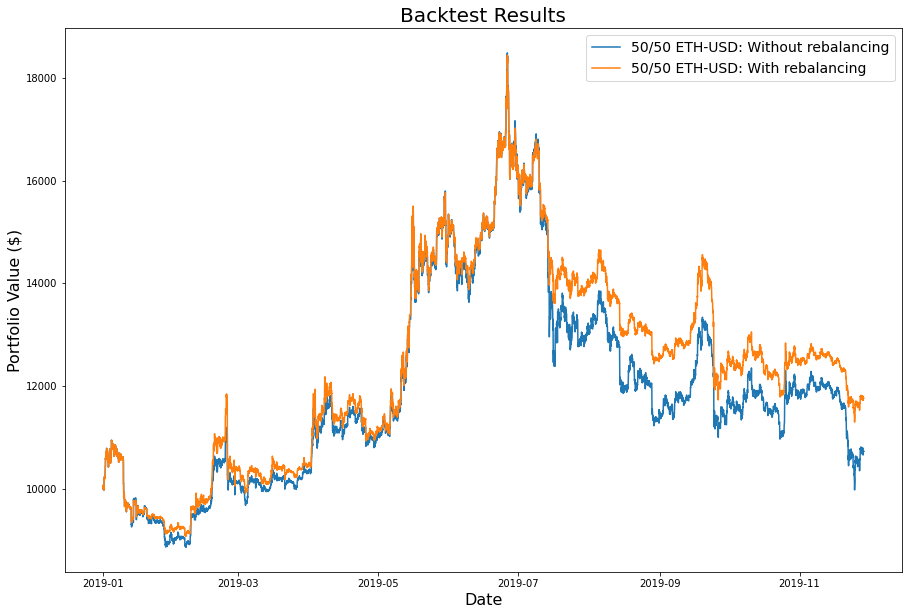

In [16]:
import matplotlib.pyplot as plt

# Set dates as index for running totals
running_totals.index = pd.DatetimeIndex(df['date'])


fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(running_totals)

ax.legend(running_totals.columns, loc='upper right', fontsize=14)
ax.set_ylabel('Portfolio Value ($)', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_title('Backtest Results', fontsize=20)

plt.show()

## Conclusion
I hope this analysis provides some basic clarity on the logic involved with backtests.  Some caveats to notice when running your own backtests:
* This model does not account for overfitting or underfitting.
    * This model is based on the sole performance of 11 months of price discovery and 34 trades.  Accurate backtests should have enough data for several hundred or thousand trades to improve accuracy and account for all types of price movement.
    * Price movement in datasets should include several bullish, bearish, and sideways trends.
    * The more data the better!
* Trading on a live market is not the same as trading on static historical prices.
* Slippage based on order size is not factored in.
* Models are dynamic and the best model today may not be the best model tomorrow.